# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
#transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(512),  # Slightly larger than 480 for random crop
    transforms.RandomCrop(480),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((480, 480)),
    transforms.CenterCrop((480, 480)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 30
Number of valid images: 30
Number of test images: 30


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cpu device


torch.Size([8, 480, 480, 3])
tensor([12,  5,  1, 12,  4, 12, 12,  1,  0,  0,  0,  3, 12, 12, 12,  0, 12, 12,
         2, 12, 12,  0, 12, 12, 12, 12, 12, 12,  0,  0, 12, 12, 12,  3, 12, 12,
        12, 12, 12, 12, 12, 12, 10,  6,  9,  9,  6, 12,  6,  6,  6, 12, 12,  6,
        12,  6, 12, 11,  7, 12, 12, 12,  8,  7])
tensor([[12,  5,  1, 12,  4, 12, 12,  1],
        [ 0,  0,  0,  3, 12, 12, 12,  0],
        [12, 12,  2, 12, 12,  0, 12, 12],
        [12, 12, 12, 12,  0,  0, 12, 12],
        [12,  3, 12, 12, 12, 12, 12, 12],
        [12, 12, 10,  6,  9,  9,  6, 12],
        [ 6,  6,  6, 12, 12,  6, 12,  6],
        [12, 11,  7, 12, 12, 12,  8,  7]])


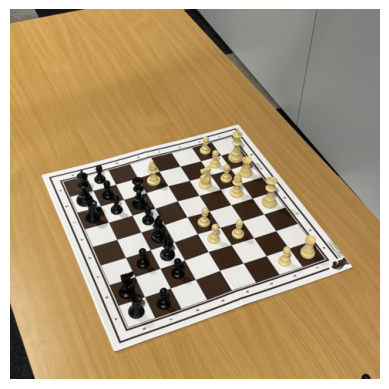

torch.Size([8, 480, 480, 3])
tensor([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0, 12,  0, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  8,  9, 11, 10,  9,  8,  7])
tensor([[ 1,  2,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0,  0,  0,  0, 12,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12,  0, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9,  8,  7]])


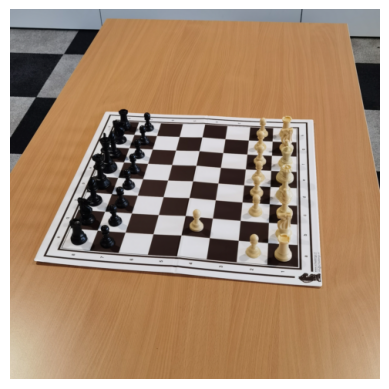

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[0])
    print(labels[0].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[1])
    print(labels[1].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cpu device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def calculate_chess_accuracy(y_true, y_pred):
    """
    Calculate chess board accuracy metrics
    Args:
        y_true: Ground truth (batch_size, 64)
        y_pred: Model predictions (batch_size, 64)
    Returns:
        overall_acc: Total accuracy across all squares
        square_acc: List of accuracies per square
    """
    # Convert -0 to 0 (equivalent in floating point)
    y_true = np.where(y_true == -0., 0., y_true)
    y_pred = np.where(y_pred == -0., 0., y_pred)
    
    # Binarize predictions if using raw outputs
    y_pred = (y_pred > 0.5).astype(float)
    
    # Calculate overall accuracy (all squares combined)
    overall_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    
    # Calculate accuracy per square
    square_acc = []
    for square_idx in range(64):
        acc = accuracy_score(y_true[:, square_idx], y_pred[:, square_idx])
        square_acc.append(acc)
    
    return overall_acc, square_acc

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    # Suggested fix:
    matches = (all_preds == all_labels).cpu().numpy()
    accuracy = np.mean(matches) * 100
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [12]:
test = [1, 2, 3]
test1 = [1, 0, 0]

# Create boolean array of matches
condition_array = np.array(test) == np.array(test1)

# Calculate percentage of correct elements
percentage_correct = np.mean(condition_array) * 100

print("Matching elements array:", condition_array)
print(f"Percentage correct: {percentage_correct:.1f}%")

Matching elements array: [ True False False]
Percentage correct: 33.3%


Define loss, optimizer and train the model

In [13]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 1

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 3/3 [00:22<00:00,  7.37s/it]


Train loss: 23.94255 	 Train acc: 10.48177


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Val loss: 17.04526 	 Val acc: 6.92708
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [14]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

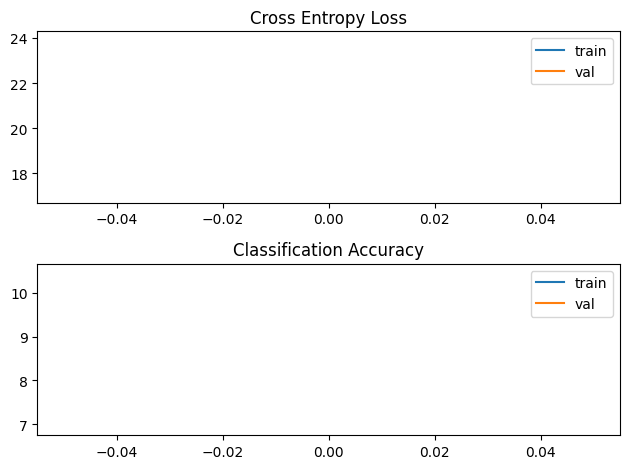

In [15]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [16]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        preds.extend(predsTmp.round().astype(int).squeeze())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu().detach().numpy()
        labels.extend(original_values)
    print(labels[:1],preds[:1])
    preds_np = np.array(preds)
    labels_np = np.array(labels)
    matches = (preds_np == labels_np)
    accuracy = np.mean(matches) * 100
    return accuracy
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

[array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7], dtype=int64)] [array([ 4,  3,  6,  7,  5,  6, 11,  2,  4,  2,  1,  5,  4,  9,  8,  3, 11,
        8,  7,  9,  9,  3, 10,  9, 10, 11, 10,  8,  5,  1, 10, 10, 11, 10,
       10, 10, 11,  9,  8, 10, 10, 10,  8,  9, 10, 10,  9,  9,  6,  6,  7,
        8,  9,  8, 10,  6,  9,  9,  9, 11, 10, 10,  9,  6])]
Test loss: 7.344


  0%|          | 0/4 [00:00<?, ?it/s]

[[ 4.  3.  6.  7.  5.  6. 11.  2.]
 [ 4.  2.  1.  5.  4.  9.  8.  3.]
 [11.  8.  7.  9.  9.  3. 10.  9.]
 [10. 11. 10.  8.  5.  1. 10. 10.]
 [11. 10. 10. 10. 11.  9.  8. 10.]
 [10. 10.  8.  9. 10. 10.  9.  9.]
 [ 6.  6.  7.  8.  9.  8. 10.  6.]
 [ 9.  9.  9. 11. 10. 10.  9.  6.]]
[[ 1  2  3  5  4  3  2  1]
 [ 0  0  0  0  0  0  0  0]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  6]
 [ 7  8  9 11 10  9  8  7]]


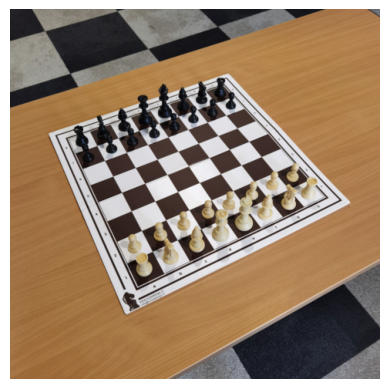

 25%|██▌       | 1/4 [00:02<00:08,  2.91s/it]

[[ 3.  2.  6.  7.  5.  6. 11.  2.]
 [ 3.  1.  1.  5.  3. 10.  9.  2.]
 [11.  9.  7. 10. 10.  2. 11. 10.]
 [11. 11. 11.  9.  5.  1. 11. 11.]
 [11. 10. 10. 10. 12.  9.  8. 10.]
 [11. 10.  9. 10. 11. 11. 10. 10.]
 [ 6.  6.  7.  9. 10.  9. 10.  6.]
 [10. 10. 10. 11. 11. 11. 10.  7.]]
[[ 1 12  3  5  4 12  2  1]
 [ 0  0  0 12  0  0  3  0]
 [12 12  2  0 12 12 12 12]
 [12 12 12 12 12 12  0 12]
 [12 12  9 12  6 12 12 12]
 [12 12  8  6 12 12 12 12]
 [ 6  6  6 12 12  6  6  6]
 [ 7 12  9 11 10 12  8  7]]


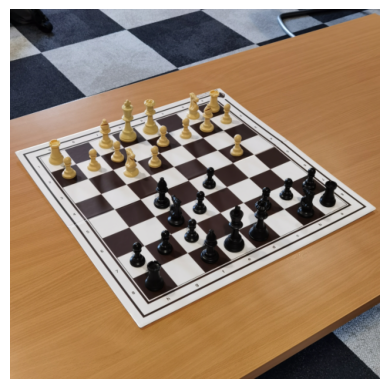

 50%|█████     | 2/4 [00:05<00:05,  2.64s/it]

[[ 3.  3.  6.  7.  5.  6. 11.  2.]
 [ 3.  2.  1.  5.  3.  9.  8.  3.]
 [11.  8.  7.  9.  9.  3. 10.  9.]
 [11. 11. 11.  8.  5.  1. 10. 10.]
 [11. 10. 10. 10. 11.  9.  8. 10.]
 [10. 10.  9.  9. 10. 10.  9.  9.]
 [ 6.  6.  7.  8. 10.  8. 10.  6.]
 [10. 10.  9. 11. 10. 10. 10.  6.]]
[[ 1 12 12  5  4 12 12  1]
 [ 0  0  0  3  0 12  3 12]
 [12 12  2  0 12  2 12  0]
 [12 12 12 12 12  0  0 12]
 [12 12  9 12  6 12 12 12]
 [ 6 12  8  6  9  6 12 12]
 [12  6  6 12  8 12  6  6]
 [ 7 12 12 11 10 12 12  7]]


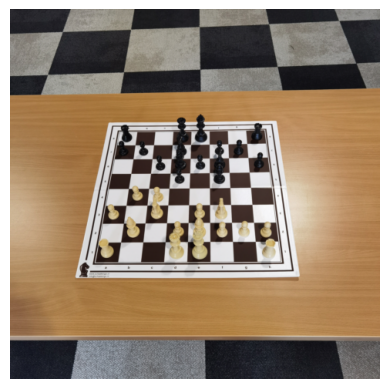

 75%|███████▌  | 3/4 [00:08<00:02,  2.70s/it]

[[ 4.  3.  6.  7.  5.  6. 11.  2.]
 [ 4.  2.  1.  5.  4.  9.  8.  3.]
 [11.  8.  7.  9.  9.  3. 10.  9.]
 [10. 11. 10.  8.  5.  1. 10. 10.]
 [11. 10. 10. 10. 11.  9.  8. 10.]
 [10. 10.  8.  9. 10. 10.  9.  9.]
 [ 6.  6.  7.  8.  9.  8. 10.  6.]
 [ 9.  9.  9. 11. 10. 10.  9.  6.]]
[[12  5  1 12  4 12 12  1]
 [ 0  0  0 12 12 12  3 12]
 [12 12  2  0  9  2 12  0]
 [12 12 12 12  0 12  0 12]
 [12 12 12 12  0 12 12 12]
 [ 6 12  8  6  9  6 12  6]
 [12  6  6 10  8 12  6 12]
 [12 11  7 12 12 12 12  7]]


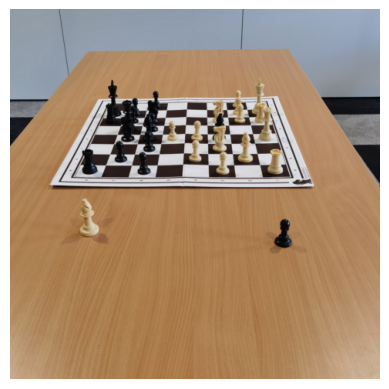

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


In [18]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    tests = 5
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        print(predsTmp[0].round().reshape(8, 8))
        print(y.cpu()[0].reshape(8, 8).numpy())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        imgs = X.cpu()
        imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
        plt.imshow(imgs[0])
        plt.axis('off')
        plt.show()
        tests -= 1
        if(tests<0):
            break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?